# Evaluator Inputs

In [1]:
file_train = "stocks2019.csv"
file_test = "stocks2020.csv"
timeout = 3600

#### Assign 'm' Constraint on # of Stocks Selected for Portfolio

In [2]:
import pandas as pd
# Number of stocks in index
n = pd.read_csv(file_train).shape[1]-2

# Select an m constraint
m = None
while True:
    try:
        m = int(input('How many stocks would you like to select for m (INTEGERS ONLY)? The index has {} stocks.'.format(n)))
        if m <= n:
            break
        else:
            print('Your choice of stocks is greater than the maximum number of stocks in the index. Try again.')
            print('\n')
    except:
        print('That was not an integer. Try again.')
        print('\n')

original_m = m

---

---

---

---

# Setup

In [89]:
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [4]:
#Import Prices
def stockDF(csv, dates='X'):
    df = pd.read_csv(csv).rename(columns = {dates:'Date'})
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

#Calculate Returns
def returnsDF(df):
    df = df/df.shift(1)-1
    return df[1:]

#Optimize x
def optimize(obj, A, B, sense, vtype='C', minimize=False, m=None):    
    # run gurobi optimization
    if m:
        B[0] = m #if using an m stock limit, then make the first constraint = m stocks
    
    model = gp.Model()

    modX = model.addMVar(len(obj), vtype=[vtype]*len(obj))
    modCon = model.addMConstrs(A, modX, sense, B)
    
    if minimize:
        model.setMObjective(None, obj, 0, sense = gp.GRB.MINIMIZE)
    else:
        model.setMObjective(None, obj, 0, sense = gp.GRB.MAXIMIZE)

    model.Params.OutputFlag = 0
    model.Params.TimeLimit = timeout
    
    try:
        model.optimize()
    except Exception as e:
        print(e)
    
    if model.solCount == 0:
        print("Model is infeasible")
    
    return model.objVal, modX.x


#Run correlation optimization and output selected stocks
def optimize_corr(m):
    #Optimize
    corrobjVal, corrX = optimize(corrobj, corrA, corrB, corrsense, vtype='B', m=m)
    
    #Resize the selected correlations to an interpretable matrix.
    #Each row is binaries of a portfolio stock and all of the index stocks that it represents.
    corrX = corrX[-length*length:].reshape(length,length)
    binarydf = pd.DataFrame(corrX, index = rho.index, columns = rho.columns).replace(0, np.nan)

    #Show how many index stocks each port stock represents. (Sum of row binaries).
    portstocks = binarydf.T.sum().sort_values(ascending=False)[:m]

    #Create and index list with the stock tickers
    stockids = list(portstocks.index)
    
    return corrobjVal, portstocks, stockids, binarydf


#Optimize weights with given stocks
def optimize_weights(retdf, stockids):
    #create a flexible t variable to genericize code for different frequency and/or lengths of time
    t = retdf.shape[0]
    m = len(stockids)
    
    #Constraint 1: All weights must add up to 1
    weightscon = np.array([[1]*m+[0]*t])

    #Constraint 2: Difference in portfolio returns and index return generates an error (slack) variable.
    #Portfolio return in a function of constant coefficients and weight variables.
    #Error variables are effectively an identity matrix taking 1 times error for that day.
    #RHS is the index's true return, which is a constant.

    #Math Basis: 
    #       stockrets*[w]s - actual return = [error slack]
    #Absolute Value:
    #       stockrets*[w]s - actual return <= [error slack]
    #       actual return - stockrets*[w]s <= [error slack] OR -stockrets*[w]s + actual return <= [error slack]

    #Reordered with Variables on LHS and Constants on RHS:
    #       stockrets*[w]s - [error slack] = actual return
    #Absolute Value:
    #       stockrets*[w]s - [error slack] <= actual return
    #       -stockrets*[w]s - [error slack] <= -actual return

    #Create stockrets matrix for coefficients of weights (constants)
    stockrets = retdf[stockids].values
    #Make the negative mirror for absolute value
    stockrets2 = -stockrets

    #Create the slack variable identity matrix (negative)
    slack = np.eye(t)*-1

    #Add the slack for each period to the right of the returns for that period in both 'mirrors'
    stockretscon = np.concatenate((stockrets, slack),axis=1)
    stockrets2con = np.concatenate((stockrets2, slack),axis=1)

    #Concatenate a whole constraint matrix with weights and both 'mirrors' of error matrices
    constr = np.concatenate((weightscon, stockretscon, stockrets2con))
    
    #Create the actual returns matrix (constants)
    actrets = retdf.iloc[:,0].values
    actrets2 = -actrets

    #Concatenate a whole RHS matrix with weight total and both 'mirrors' of actual returns matrices
    rhs = np.concatenate((np.array([1]),actrets, actrets2))
    rhs.shape
    
    ### Gurobi Inputs
    #objective is sum of error slack variables for all periods
    obj = [0]*m + [1]*t
    obj = np.array(obj)
    A = constr
    B = rhs
    sense = ['='] + ["<"]*t*2 #twice as long because of absolute values
    
    ###Optimize for weights
    errorsum, weightX = optimize(obj, A, B, sense, vtype='C', minimize=True)
    
    #weights series
    weights = pd.Series(weightX[:m], index = stockids)
    
    #errors (slack variables) df
    errors = pd.Series(weightX[m:])
    errors = errors.to_frame(name='Errors')
    
    return errorsum, weights, errors

#Evaluate portfolio error on test data
def track_error(retdf, stockids, weights):
    #calculate the portfolio returns
    portrets_test = retdf[stockids] @ weights

    #Actual returns for test data
    actrets_test = retdf.iloc[:,0]

    #Calculate test error
    errors_test = portrets_test - actrets_test
    errors_test = pd.Series(errors_test, index = retdf.index)
    
    return abs(errors_test).sum(), errors_test

# Training Data Pre-Processing (& Test Data Import)

In [5]:
#import the train and test csv files as dfs
df_train = stockDF(file_train)
df_test = stockDF(file_test)

#create train and test returns dfs
ret_train = returnsDF(df_train)
ret_test = returnsDF(df_test)

ret_train.head()

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.033602,-0.035509,-0.039498,-0.094530,0.022030,-0.085791,-0.027696,-0.028484,-0.025242,-0.015216,...,-0.022834,-0.018591,-0.034989,-0.030557,-0.002133,-0.010435,-0.035808,-0.068217,-0.003940,-0.037651
2019-01-04,0.044824,0.039903,0.048632,0.114370,0.057779,0.010445,0.051294,0.053786,0.050064,0.034184,...,0.058976,0.047954,0.044744,0.044147,0.054785,0.033269,0.060577,0.042356,0.009786,0.046303
2019-01-07,0.010211,0.028196,0.013573,0.082632,0.018302,0.017192,-0.001994,-0.002167,0.034353,0.013457,...,0.022067,0.062620,0.016312,0.001000,0.018240,0.005749,0.000918,0.035522,-0.004330,0.026415
2019-01-08,0.009802,0.030309,0.014918,0.008751,0.006207,0.015954,0.008783,0.007385,0.016612,0.012824,...,0.010281,0.018450,0.036460,0.008902,0.013307,0.020009,0.021101,-0.009615,0.011597,-0.019051
2019-01-09,0.007454,0.017210,0.011819,-0.026988,0.012430,0.038196,-0.003427,-0.001505,0.001714,-0.001196,...,0.023745,0.018804,-0.008157,0.003781,0.023065,0.012050,-0.004612,0.044083,-0.007984,0.008972


In [6]:
#create a train correlation matrix df
rho = ret_train.iloc[:,1:].corr()

#create a flexible length variable to genericize code for different sized indexes
length = rho.shape[0]

rho.tail()

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
WBA,0.218149,0.228106,0.281950,0.192720,0.219595,0.232900,0.230603,0.288168,0.194490,0.347861,...,0.257049,0.145330,0.195475,0.126118,0.214585,1.000000,0.211641,0.296309,-0.130798,0.276643
WDAY,0.311659,0.650430,0.407626,0.416396,0.308968,0.379493,0.371826,0.424748,0.211712,0.351734,...,0.235045,0.269545,0.569672,0.401476,0.376047,0.211641,1.000000,0.315699,0.209240,0.254117
WDC,0.303077,0.361516,0.438892,0.289908,0.284407,0.328619,0.322110,0.419620,0.172623,0.602935,...,0.377215,0.126463,0.331916,0.308558,0.314773,0.296309,0.315699,1.000000,-0.076115,0.516958
XEL,0.043389,0.207403,0.017283,0.047947,0.088059,0.059930,0.052570,0.076724,0.137857,-0.047259,...,-0.172752,0.074686,0.280371,0.407770,0.191667,-0.130798,0.209240,-0.076115,1.000000,-0.117552
XLNX,0.249667,0.289497,0.478010,0.200356,0.253934,0.221983,0.213764,0.389871,0.092808,0.687646,...,0.415079,0.142450,0.352529,0.193846,0.166732,0.276643,0.254117,0.516958,-0.117552,1.000000


#### Training Data Constraints

In [7]:
# Constraint 2 - all stocks (100 rows)
# Each stock in the index can only be represented by 1 stock in the portfolio
# Stack 100 identities horizontally to add up each portfolio stock representing an index stock and set to 1
eye = np.eye(length)
tile = np.tile(eye,length)
tile.shape

(100, 10000)

In [8]:
# Constraint 3 - fund stocks can only represent index stocks if selected
repeat2 = np.repeat(eye*-1,length, axis=0)
eye10k = np.eye(length*length)
constr3 = np.concatenate((repeat2, eye10k), axis=1)
constr3.shape

(10000, 10100)

#### Gurobi Inputs

In [9]:
corrA = np.zeros([length*(length+1)+1,length*(length+1)])
corrA[0, :length] = 1 # Constraint 1 - total stocks selected must be m
corrA[1:length+1, length:] = tile
corrA[length+1:] = constr3
corrA.shape

(10101, 10100)

In [10]:
corrB = np.array([m] + [1]*length + [0]*length*length)
corrB

array([5, 1, 1, ..., 0, 0, 0])

In [11]:
corrsense = np.array(['<']*(length*(length+1)+1))
corrsense.shape

(10101,)

In [12]:
corrobj = np.concatenate(([0]*length, rho.values.flatten()), axis=0)
corrobj.shape

(10100,)

---

---

---

---

# Output - Optimize with 'm' Stocks

#### Optimize Stock Selection

In [13]:
corrsum, portstocks, stockids, binarydf = optimize_corr(m)
display(corrsum, portstocks, stockids)

orig_corrsum = corrsum
orig_portstocks = portstocks

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-19


54.839906522291066

MSFT     53.0
MXIM     30.0
VRTX     10.0
XEL       4.0
LBTYK     3.0
dtype: float64

['MSFT', 'MXIM', 'VRTX', 'XEL', 'LBTYK']

In [14]:
#Correlation averages for portfolio stock and their index constituents
(rho*binarydf).loc[stockids].T.mean()

MSFT     0.521191
MXIM     0.573980
VRTX     0.507679
XEL      0.644000
LBTYK    0.781527
dtype: float64

#### Optimize Weights

In [15]:
errorsum, weights, errors = optimize_weights(ret_train, stockids)
errorsum, weights

(0.7891782824631471,
 MSFT     0.580352
 MXIM     0.210388
 VRTX     0.071190
 XEL      0.089208
 LBTYK    0.048862
 dtype: float64)

# Output - Manual Evaluation

#### Training Set Validation

In [16]:
trainsum, trainerrors = track_error(ret_train, stockids, weights)

display(trainsum) #manual error calculation
display(abs(errors.values).sum()) #gurobi error calculation

0.7891782824631475

0.7891782824631475

#### Test Set Evaluation

In [17]:
testsum, testerrors = track_error(ret_test, stockids, weights)
display(testsum)

0.8696699433741899

# Output - Evaluating Various #s ('m') of Portfolio Stocks

In [98]:
#m = 10, 20, 30, 40, 50, 60, 70, 80, 90, 100
m_array = np.arange(10,101,10)
total_error = []

#loop through all m values and evaluate on test data
for m in m_array:
    corrsum, portstocks, stockids, binarydf = optimize_corr(m) #select stocks
    errorsum, weights, errors = optimize_weights(ret_train, stockids) #select weights
    testsum, testerrors = track_error(ret_test, stockids, weights) #evaluate on test data
    total_error.append(testsum)

#dataframe of errors results for m values
mdf = pd.DataFrame({'Test Error': total_error}, index = m_array)
mdf['Test Error - {} Days Extrapolated'.format(len(ret_train))] = mdf['Test Error']/len(ret_test)*len(ret_train)
mdf

,Test Error,Test Error - 250 Days Extrapolated
10,0.838888,1.115542
20,0.652338,0.867471
30,0.573739,0.762951
40,0.600102,0.798008
50,0.582092,0.774059
60,0.798892,1.062357
70,0.613753,0.816161
80,0.393494,0.523263
90,0.247582,0.329231
100,0.249936,0.332362


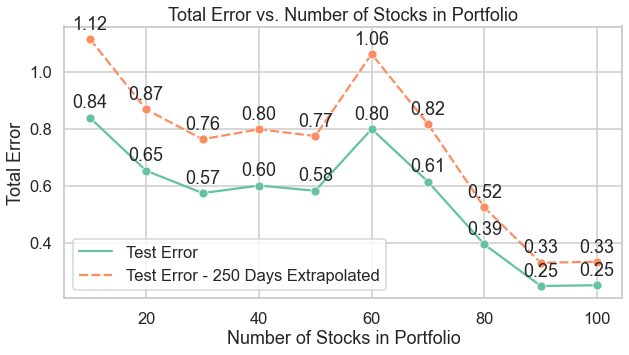

In [110]:
plt.figure(figsize=(10,5))

#m vs error plot
sns.set_style("whitegrid")
sns.lineplot(data=mdf, marker='o')
plt.xlabel('Number of Stocks in Portfolio')
plt.ylabel('Total Error')
plt.title('Total Error vs. Number of Stocks in Portfolio')
for x,y in zip(mdf.index, mdf['Test Error']):
    label = "{:.2f}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
for x,y in zip(mdf.index, mdf['Test Error - {} Days Extrapolated'.format(len(ret_train))]):
    label = "{:.2f}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()


# Big M Constraint

In [19]:
def bigMopt(m):
    #create a flexible t variable to genericize code for different frequency and/or lengths of time
    t = ret_train.shape[0]

    #Constraint 1: All selected stocks must add up to m
    mcon = np.array([[1]*n + [0]*n + [0]*t])

    #Constraint 2: All weights must add up to 1
    weightscon = np.array([[0]*n + [1]*n + [0]*t])

    #Create stockrets matrix for coefficients of weights (constants)
    stockrets = ret_train.iloc[:,1:1+n].values
    #Make the negative mirror for absolute value
    stockrets2 = -stockrets

    #Create the slack variable identity matrix (negative)
    slack = np.eye(t)*-1

    #Add the slack for each period to the right of the returns for that period in both 'mirrors'
    stockretscon = np.concatenate((np.zeros((t,n)),stockrets, slack),axis=1)
    stockrets2con = np.concatenate((np.zeros((t,n)),stockrets2, slack),axis=1)

    #Big M matrix
    bigMcon = np.concatenate((np.eye(n)*-1, np.eye(n), np.zeros((n,t))), axis=1)

    #Concatenate a whole constraint matrix with weights and both 'mirrors' of error matrices
    constr = np.concatenate((mcon, weightscon, bigMcon, stockretscon, stockrets2con))

    #Create the actual returns matrix (constants)
    actrets = ret_train.iloc[:,0].values
    actrets2 = -actrets

    #Concatenate a whole RHS matrix with weight total and both 'mirrors' of actual returns matrices
    rhs = np.concatenate(([m],[1],[0]*n,actrets, actrets2))

    ### Gurobi Inputs
    #objective is sum of error slack variables for all periods
    obj = [0]*(2*n) + [1]*t
    obj = np.array(obj)
    A = constr
    B = rhs
    sense = ['=']*2 + ["<"]*(n+t*2) #twice as long because of absolute values

    ### Optimize with Gurobi

    model = gp.Model()

    modX = model.addMVar(len(obj), vtype=['B']*n + ['C']*(n+t))
    modCon = model.addMConstrs(A, modX, sense, B)

    model.setMObjective(None, obj, 0, sense = gp.GRB.MINIMIZE)

    model.Params.OutputFlag = 0
    model.Params.TimeLimit = timeout

    try:
        model.optimize()
    except Exception as e:
        print(e)

    if model.solCount == 0:
        print("Model is infeasible")

    X = modX.x

    # create a dataframe of the selected stocks, X, and their weights
    stockdf = pd.DataFrame({'Stock': rho.index[:n], 'X': X[:n], 'Weight': X[n:n*2]})

    # return stocks where x = 1
    ids = stockdf[stockdf['X'] == 1]['Stock'].values

    # return stockdf weight where stock is in ids
    weights = stockdf[stockdf['Stock'].isin(ids)]['Weight'].values

    testerror, testdf = track_error(ret_test, ids, weights)

    return model.objVal, modX.x, stockdf, testerror, testdf

In [20]:
##### Simplifying the test run with smaller number of stocks in both the index and the fund


# input an n that is <= len(rho) and >0
while True:
    try:
        n = input("Enter a number between 1 and {}. (Or press ENTER for default value of {})".format(len(rho), len(rho)))
        if n == '':
            n = len(rho)
            break
        else:
            n = int(n)
            if n <= 0 or n > len(rho):
                print("Invalid number. Try again.")
            else:
                break
    except ValueError:
        print("Invalid number. Try again.")


# select an m <= n
while True:
    try:
        m = int(input('How many stocks would you like to select for m (INTEGERS ONLY)? Maximum = {}'.format(n)))
        if m <= n and m > 0:
            break
        else:
            print('Your choice of stocks is invalid. Try again.')
            print('\n')
    except:
        print('That was not an integer. Try again.')
        print('\n')

trainerror, trainX, stockdf, testerror, testdf = bigMopt(m)

stockdf

,Stock,X,Weight
0,ATVI,0.0,0.0
1,ADBE,-0.0,0.0
2,AMD,0.0,0.0
3,ALXN,0.0,0.0
4,ALGN,0.0,0.0
...,...,...,...
95,WBA,0.0,0.0
96,WDAY,0.0,0.0
97,WDC,0.0,0.0
98,XEL,0.0,0.0


# Long Question - Iterate Over Multiple Values of m (will be short if you chose a small n earlier. REMEMBER: the "10-hr" n we need to turn in is 100.)

In [21]:
m_array = np.arange(np.ceil(n/10),np.ceil(n+1),np.ceil(n/10)).astype(int)

stockdfs = []
trainerrors = []
testerrors = []
for m in m_array:
    trainerror, trainX, stockdf, testerror, testdf = bigMopt(m)
    stockdfs.append(stockdf)
    trainerrors.append(trainerror)
    testerrors.append(testerror)
    print('m = {}'.format(m))
    print('Trainerror = {}'.format(trainerror))
    print('Testerror = {}'.format(testerror))
    print('\n')

#dataframe of errors results for m values
errordf = pd.DataFrame({'Train Error': trainerrors, 'Test Error': testerrors}, index = m_array)
errordf

m = 10
Trainerror = 0.3018622466422535
Testerror = 0.5182203723542852


m = 20
Trainerror = 0.15750137571614828
Testerror = 0.4074569525160368


m = 30
Trainerror = 0.1096518769909111
Testerror = 0.3572869674680218


m = 40
Trainerror = 0.08252039283448265
Testerror = 0.29502468189233616


m = 50
Trainerror = 0.061025439778543085
Testerror = 0.27278868397768424


m = 60
Trainerror = 0.052295212006035784
Testerror = 0.2541112885671767


m = 70
Trainerror = 0.04775059974948952
Testerror = 0.24205612060734377


m = 80
Trainerror = 0.04522712091896977
Testerror = 0.2491430959076978


m = 90
Trainerror = 0.04491081639360336
Testerror = 0.24994327434030217


m = 100
Trainerror = 0.044910816408392805
Testerror = 0.24993623175722907




,Train Error,Test Error
10,0.301862,0.518220
20,0.157501,0.407457
30,0.109652,0.357287
40,0.082520,0.295025
50,0.061025,0.272789
60,0.052295,0.254111
70,0.047751,0.242056
80,0.045227,0.249143
90,0.044911,0.249943
100,0.044911,0.249936


# Summary

In [118]:
# normalizing test error to training data length (annual)
errordf['Test Error - {} Days Extrapolated'.format(len(ret_train))] = errordf['Test Error']/len(ret_test)*len(ret_train)

errdf1 = mdf
errdf2 = errordf[['Test Error', 'Test Error - {} Days Extrapolated'.format(len(ret_train))]]

errdf2

,Test Error,Test Error - 250 Days Extrapolated
10,0.518220,0.689123
20,0.407457,0.541831
30,0.357287,0.475116
40,0.295025,0.392320
50,0.272789,0.362751
60,0.254111,0.337914
70,0.242056,0.321883
80,0.249143,0.331307
90,0.249943,0.332371
100,0.249936,0.332362


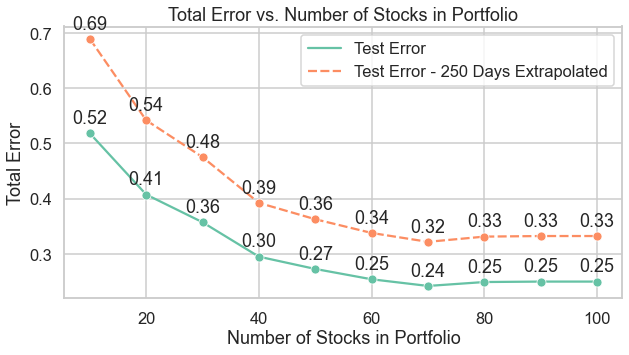

In [121]:
#plotting the test error for each m value
errordf['Test Error - {} Days Extrapolated'.format(len(ret_train))] = errordf['Test Error']/len(ret_test)*len(ret_train)

plt.figure(figsize=(10,5))

#m vs error plot
sns.set_style("whitegrid")
sns.lineplot(data=errdf2, marker='o')
plt.xlabel('Number of Stocks in Portfolio')
plt.ylabel('Total Error')
plt.title('Total Error vs. Number of Stocks in Portfolio')
for x,y in zip(errdf2.index, errdf2['Test Error']):
    label = "{:.2f}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
for x,y in zip(errdf2.index, errdf2.iloc[:,1]):
    label = "{:.2f}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()


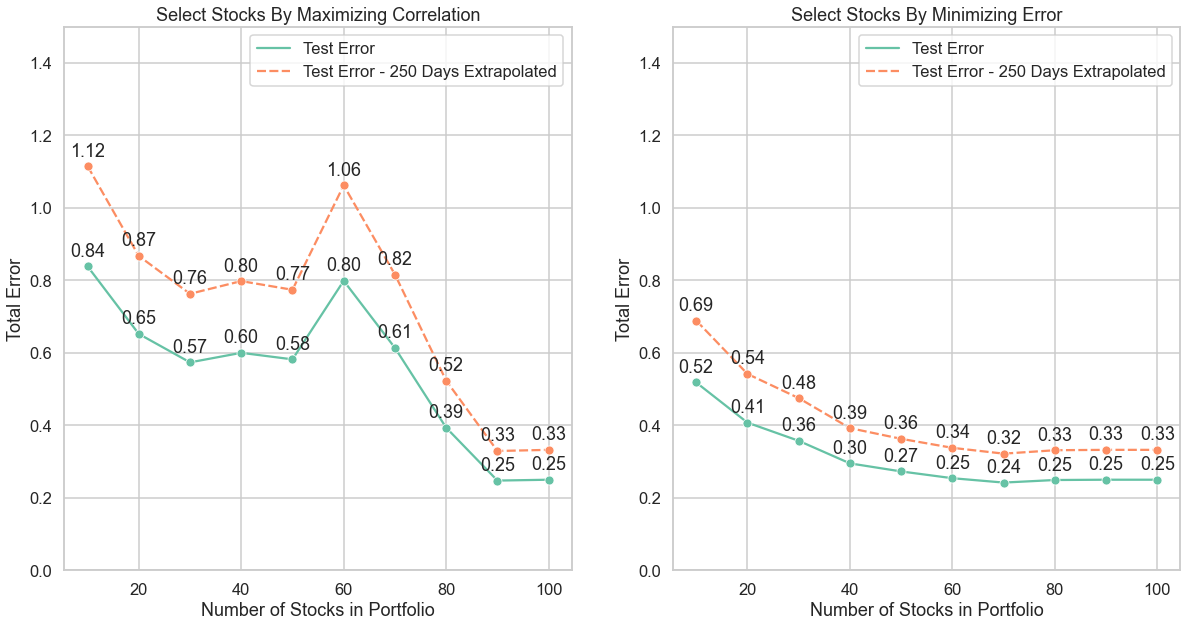

In [140]:
#plotting test errors for each method at each m value
errdf1 = mdf
errdf2 = errordf[['Test Error', 'Test Error - {} Days Extrapolated'.format(len(ret_train))]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_ylim(0, 1.5)
ax2.set_ylim(0, 1.5)

#first plot
sns.set_style("whitegrid")
sns.lineplot(data=errdf1, marker='o', ax=ax1)
ax1.set_xlabel('Number of Stocks in Portfolio')
ax1.set_ylabel('Total Error')
ax1.set_title('Select Stocks By Maximizing Correlation')
for x,y in zip(errdf1.index, errdf1['Test Error']):
    label = "{:.2f}".format(y)
    ax1.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
for x,y in zip(errdf1.index, errdf1.iloc[:,1]):
    label = "{:.2f}".format(y)
    ax1.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')

#big M plot
sns.set_style("whitegrid")
sns.lineplot(data=errdf2, marker='o', ax=ax2)
ax2.set_xlabel('Number of Stocks in Portfolio')
ax2.set_ylabel('Total Error')
ax2.set_title('Select Stocks By Minimizing Error')
for x,y in zip(errdf2.index, errdf2['Test Error']):
    label = "{:.2f}".format(y)
    ax2.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
for x,y in zip(errdf2.index, errdf2.iloc[:,1]):
    label = "{:.2f}".format(y)
    ax2.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

In [178]:
# calculating total costs by factoring in transaction costs with various estimates of transactions costs
# total cost = 250-day test error + transaction costs * m (assuming 0.25%, 0.5%, 0.75%, and 1% transaction costs)

tcs = [0.0025, 0.005, 0.0075, 0.01, 0.0125]
tcdfs = []
tcmins = []
for tc in tcs:
    tc = tc
    tempdf = errordf.copy()
    tempdf['Transaction Costs'] = tc*tempdf.index
    tempdf['Total Cost'] = tempdf.iloc[:, 2] + tempdf['Transaction Costs']
    tcdfs.append(tempdf)
    tcmins.append(tempdf.sort_values('Total Cost').reset_index().head(1))
tcmins = pd.concat(tcmins)
tcmins.index = ['{}%'.format(tc*100) for tc in tcs]
tcmins.rename(columns = {'index': 'm'}, inplace = True)
tcmins[['m', 'Total Cost']]

,m,Total Cost
0.25%,50,0.487751
0.5%,40,0.592320
0.75%,20,0.691831
1.0%,20,0.741831
1.25%,20,0.791831


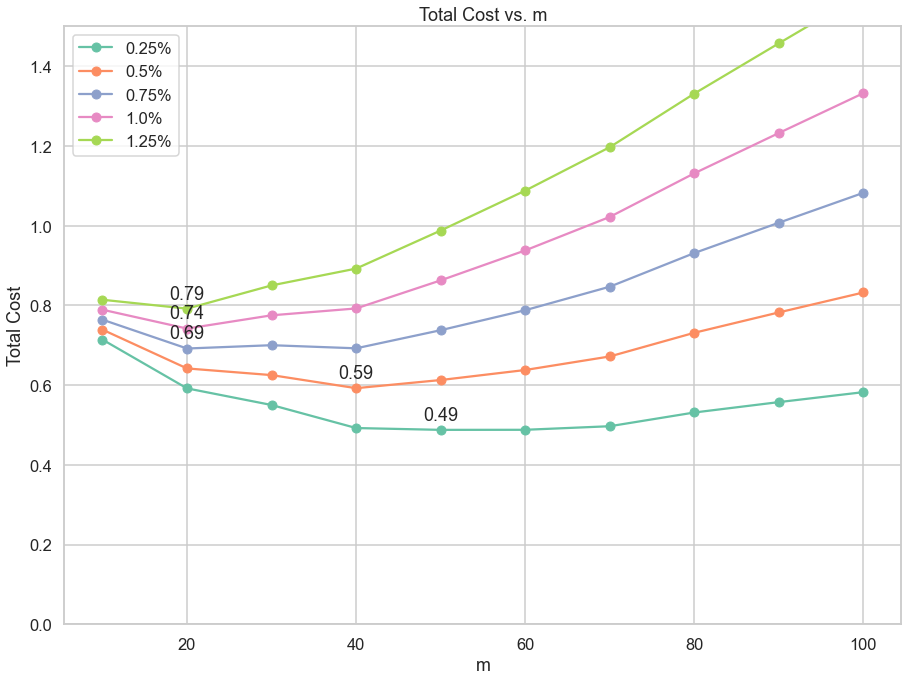

In [177]:
# plotting minimum total costs for each transaction cost estimate
fig, ax = plt.subplots(figsize=(15, 11))
for i in range(len(tcdfs)):
    ax.plot(tcdfs[i].index, tcdfs[i]['Total Cost'], label = '{}%'.format(tcs[i]*100), marker = 'o')
    for x,y in zip(tcdfs[i].index, tcdfs[i]['Total Cost']):
        label = "{:.2f}".format(y)
        if y == min(tcdfs[i]['Total Cost']):
            ax.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
ax.set_xlabel('m')
ax.set_ylim(0, 1.5)
ax.set_ylabel('Total Cost')
ax.set_title('Total Cost vs. m')
ax.legend()
plt.show()


---

---

---

---

# Appendix - Stock Selection with [201 x 10,000] Constraint Matrix
### (Instead of [10,101 x 10,100])

#### Training Data Constraints

In [22]:
# Constraint 1 - M Stocks Constraint on Whole Portfolio (1 row)
# Any selected stock is guaranteed to represent itself because corr=1
# Restrict stocks that represent themself to m.
# Add up indeces where a stock is correlated with itself and sum constrainted to m.
repeat1 = np.repeat(np.zeros([1,length]),length, axis = 1)

for i in range(length):
    repeat1[0,i*length+i] = 1

repeat1

array([[1., 0., 0., ..., 0., 0., 1.]])

In [23]:
# Constraint 2 - all stocks (100 rows)
# Each stock in the index can only be represented by 1 stock in the portfolio
# Stack 100 identities horizontally to add up each portfolio stock representing an index stock and set to 1
eye = np.eye(length)
tile = np.tile(eye,length)
tile.shape

(100, 10000)

In [24]:
# Constraint 3 - all stocks (100 rows)
# Big M: A stock disallowed to represent itself is unselected. Meaning it cannot represent anything.
# Constrain representing index stocks other than self to (n-1) times a chosen stock's representation of itself.
# If chosen = 1, can represent all others (eg; 1 self + 99 others). If chosen = 0, cannot represent any others (0 self + 0 others).
repeat3 = np.repeat(eye,length, axis = 1)

for i in range(length):
    repeat3[i, i*length+i] = -(length-1)

repeat3

array([[-99.,   1.,   1., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   1.,   1., -99.]])

#### Gurobi Inputs

In [25]:
corrA = np.zeros([length*2+1,length*length])
corrA[0] = repeat1
corrA[1:length+1] = tile
corrA[length+1:] = repeat3
corrA

array([[  1.,   0.,   0., ...,   0.,   0.,   1.],
       [  1.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   1.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   1.,   1., -99.]])

In [26]:
corrB = np.array([1] + [1]*length + [0]*length)
corrB[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [27]:
corrsense = ['<']*(2*length+1)
corrsense[:10]

['<', '<', '<', '<', '<', '<', '<', '<', '<', '<']

In [28]:
corrobj = rho.values.flatten()
corrobj[:10]

array([1.        , 0.39993857, 0.36537639, 0.22316198, 0.21627976,
       0.43309741, 0.42677746, 0.46707572, 0.20395574, 0.32935498])

# Output - Optimize with 'm' Stocks

#### Optimize Stock Selection

In [29]:
alt_corrsum, alt_portstocks, alt_stockids, alt_binarydf = optimize_corr(original_m)

display(orig_corrsum)
display(orig_portstocks)

display(alt_corrsum)
display(alt_portstocks)

54.839906522291066

MSFT     53.0
MXIM     30.0
VRTX     10.0
XEL       4.0
LBTYK     3.0
dtype: float64

54.83990652229107

MSFT     53.0
MXIM     30.0
VRTX     10.0
XEL       4.0
LBTYK     3.0
dtype: float64